# **Exercise 1:**

1. In the first exercise you will design a simpler variant of LODA. First you
will generate a 2D dataset that follows a standard normal distribution
(500 points) using **sklearn.datasets.make_blobs**.

2. Then you will randomly generate 5 unit-length projection vectors (you
can use **numpy.random.multivariate_normal** with (0, 0) mean and
identity matrix as covariance matrix) that will be used to generate 1D
histograms (for the projected values). You will compute the corresponding histograms with equal-width bins using **numpy.histogram** (for the **range** parameter use a larger interval than the range of the projected values). For each histogram compute the probability corresponding to each
bin and use them to compute the anomaly score of a sample as the mean
of the probabilities (corresponding to each histogram).

3. For testing, generate a dataset with 500 points from a uniform distribution
(between -3 and 3 using **np.random.uniform**). Plot the points in the
test dataset using a colormap (related to the anomaly scores).

4. Use different number of bins and see how this affects the score map.

In [1]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=77da41a1c3882f2309363d198c36e0381100e465278c5d079b2aa34679b57bfe
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import typing as t

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.io import loadmat
from pyod.utils.utility import standardizer

In [ ]:
# generate train data from a standard normal distribution
train_data, train_labels = make_blobs(n_samples=500, n_features=2, centers=1, center_box=(0, 0))
# generate test data from a uniform distribution
test_data = np.random.uniform(low=-3, high=3, size=(500, 2))

In [ ]:
projection_vectors_num = 5

# generate 5 unit-length vectors that will
# represents the projections used for LODA
projection_vectors = [np.random.multivariate_normal(mean=(0, 0), cov=np.identity(2)) for _ in range(projection_vectors_num)]
projection_vectors = np.array(projection_vectors)
projection_vectors = projection_vectors / np.linalg.norm(projection_vectors, axis=1, keepdims=True)

In [ ]:
def get_loda_data(
  train_data: np.ndarray,
  test_data: np.ndarray,
  projection_vectors: np.ndarray,
  projection_vectors_num: int,
  bins: int = 25,
) -> t.Tuple[t.List]:
  # project the train data onto the projection vectors
  projected_train_data = np.dot(train_data, projection_vectors.T)

  histograms = []
  bins_edges = []
  probabilities_bins = []

  for i in range(projection_vectors_num):
    # compute the minimum and maximum range for the histogram
    range_min = np.min(projected_train_data[:, i]) - 10
    range_max = np.max(projected_train_data[:, i]) + 10

    # compute the histogram
    histogram, bins_edge = np.histogram(projected_train_data[:, i], bins=bins, range=(range_min, range_max))
    # compute the probability for each bin of the histogram
    probabilities = histogram / np.sum(histogram)

    histograms.append(histogram)
    bins_edges.append(bins_edge)
    probabilities_bins.append(probabilities)

  # transform all the lists into numpy arrays
  histograms = np.array(histograms)
  bins_edges = np.array(bins_edges)
  probabilities_train_data = np.array(probabilities_bins)

  return histograms, bins_edges, probabilities_train_data

histograms_train_data, bins_edges_train_data, probabilities_bins_train_data = get_loda_data(train_data, test_data, projection_vectors, projection_vectors_num)

In [ ]:
def compute_loda_score(
    sample: np.ndarray,
    histograms: np.ndarray,
    bins_edges: np.ndarray,
    probabilities_bins: np.ndarray,
    projection_vectors: np.ndarray,
    projection_vectors_num: int
) -> float:
  """
  Given a sample, computes the probability of the sample
  belonging to the train data based on the histograms
  generated from the projection vectors.
  """
  probability = 0

  for i in range(projection_vectors_num):
    # compute the projection into the ith projection vector
    projection = np.dot(sample, projection_vectors[i])
    # find in which bin the sample belongs to
    bin = np.digitize(projection, bins_edges_train_data[i])
    # add the probability of an element belonging to the bin
    # that the sample belongs to
    probability += probabilities_bins_train_data[i][bin-1]

  probability = probability / projection_vectors_num

  return probability

In [ ]:
# get a random sample from the train data
sample_index = np.random.randint(0, len(train_data))
sample = train_data[sample_index]
# get the score as a probability from the LODA algorithm
probability = compute_loda_score(sample, histograms_train_data, bins_edges_train_data, probabilities_bins_train_data, projection_vectors, projection_vectors_num)
print(f"Probability of sample {sample_index + 1}: {probability}")

Probability of sample 130: 0.1796


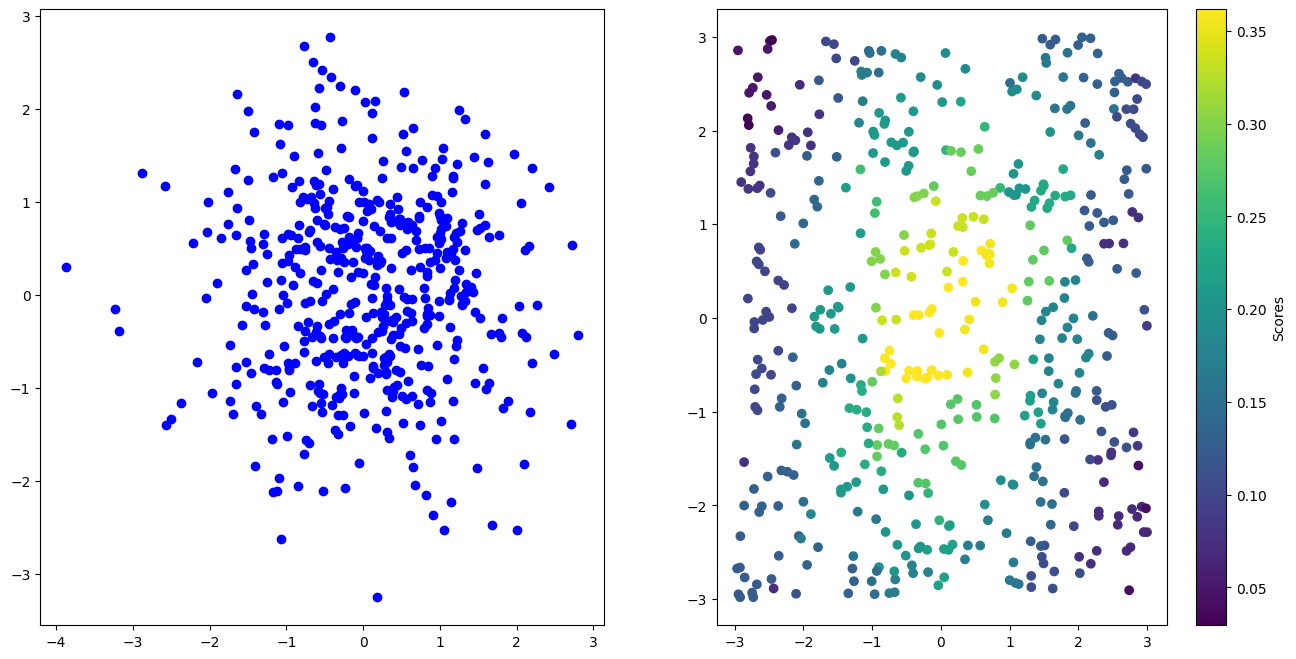

In [ ]:
# compute the scores for the test dataset
test_scores = [
    compute_loda_score(test_sample, histograms_train_data, bins_edges_train_data, probabilities_bins_train_data, projection_vectors, projection_vectors_num)
    for test_sample in test_data
]

# plot the scores
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(train_data[:, 0], train_data[:, 1], color="blue")

test_scatter = axs[1].scatter(test_data[:, 0], test_data[:, 1], c=test_scores, cmap="viridis")
plt.colorbar(test_scatter, ax=axs[1], label='Scores')

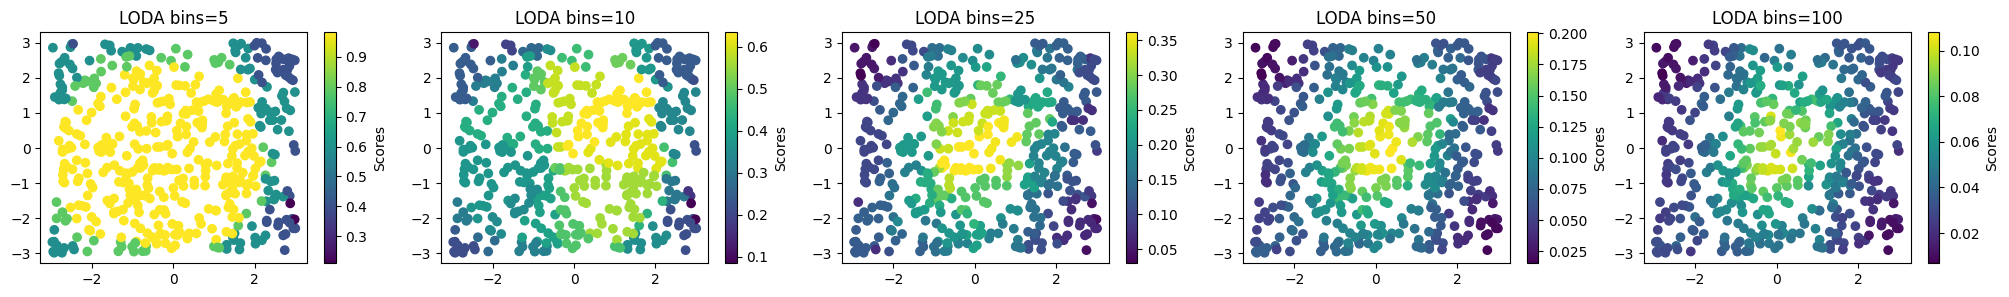

In [ ]:
loda_bins = [5, 10, 25, 50, 100]
fig, axs = plt.subplots(1, len(loda_bins), figsize=(25, 3))

for i, bins in enumerate(loda_bins):
  # compute the histograms, bins edges and probabilities
  histograms_train_data, bins_edges_train_data, probabilities_bins_train_data = get_loda_data(train_data, test_data, projection_vectors, projection_vectors_num, bins=bins)

  # compute the scores
  test_scores = [
    compute_loda_score(test_sample, histograms_train_data, bins_edges_train_data, probabilities_bins_train_data, projection_vectors, projection_vectors_num)
    for test_sample in test_data
  ]

  # add the plot to the figure
  test_scatter = axs[i].scatter(test_data[:, 0], test_data[:, 1], c=test_scores, cmap="viridis")
  plt.colorbar(test_scatter, ax=axs[i], label='Scores')
  axs[i].set_title(f"LODA bins={bins}")

plt.show()

# **Exercise 2:**

1. In this exercise we will try to see how the standard Isolation Forest algorithm introduces some artifacts when computing the anomaly scores.
You will generate 2 clusters of 2-dimensional data using **make_blobs()**
function. The 2 clusters will have **(10, 0)** and **(0, 10)** as centers, 1 as
standard deviation and **500** samples each.

2. You will fit an **IForest** model (from **pyod.models.iforest**) using this
data (and a contamination rate of **0.02**). Test data will be generated from
a uniform distribution over the interval **(-10, 20)** using **np.random.uniform** and will contain **1000** samples.

3. Find the anomaly scores for the test data and plot the samples using a colormap (related to the anomaly scores). Observe the artefacts introduced
by the axis-parallel separating hyperplanes used by standard IForest.

4. Repeat the same procedure for Deep Isolation Forest model (**DIF** from **pyod.models.dif**) and **LODA** (from **pyod.models.loda**) and use 3 subplots for the 3 figures.

5. Try different number of neurons for the hidden layers used by **DIF** and
different number of bins for **LODA**. Try to explain why the score maps
for **LODA** look that way.

6. Redo all the steps in 3D (use **(0, 10, 0)** and **(10, 0 , 10)** as centers for the two clusters).

In [3]:
from pyod.models import iforest, dif, loda

In [ ]:
# size of the train and test datasets
if_train_size = 1000
if_test_size = 1000

# generate train data with two clusters centered in (10, 0) and (0, 10)
if_train_data, if_train_labels = make_blobs(n_samples=if_train_size, centers=[(10, 0), (0, 10)], cluster_std=1)
# generate test data from uniform distribution
if_test_data = np.random.uniform(low=-10, high=20, size=(if_test_size, 2))

In [ ]:
def plot_decision_area(
  ax,
  data: np.ndarray,
  decision_area: np.ndarray
) -> None:
  """
  Plots the decision area for a given dataset and decision area.
  It handles separately the cases when the data is 2D and 3D.
  """
  if data.shape[1] == 2:
    return ax.scatter(data[:, 0], data[:, 1], c=decision_area, cmap="viridis")
  else:
    return ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=decision_area, cmap="viridis")

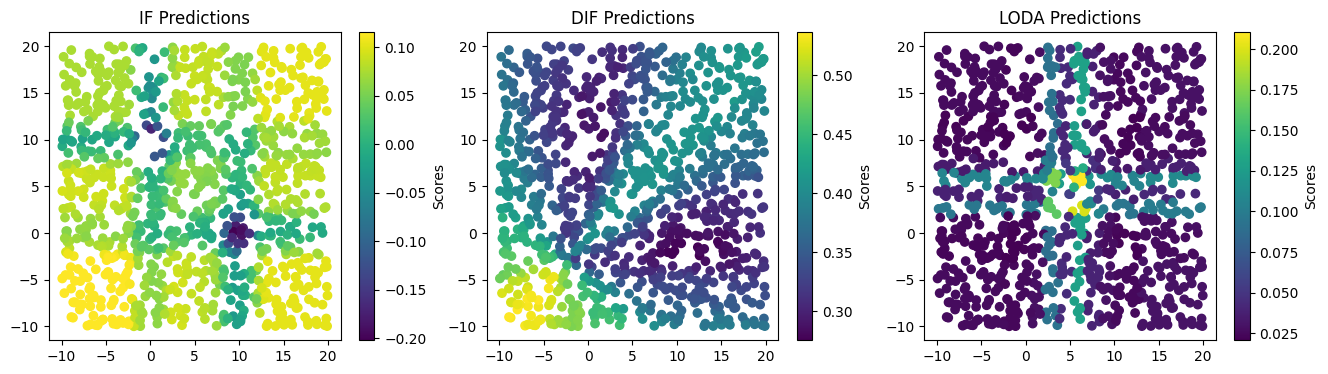

In [ ]:
def compare_if_dif_loda(
  train_data: np.ndarray,
  test_data: np.ndarray,
  contamination: float = 0.02
) -> None:
  """
  Given a train and test dataset, with a certain contamination,
  compares the IF, DIF and LODA models on them.

  Plots the decision area for each model.
  """
  _iforest = iforest.IForest(contamination=contamination)
  # fit the train data into a isolation forest
  _iforest.fit(train_data)
  # get the decision area for predictions
  if_decision_area = _iforest.decision_function(test_data)

  _diforest = dif.DIF(contamination=contamination)
  # fit the train data into a deep isolation forest
  _diforest.fit(train_data)
  # get the decision area for predictions
  dif_decision_area = _diforest.decision_function(test_data)

  _loda = loda.LODA(contamination=contamination)
  # fit the train data into a LODA model
  _loda.fit(train_data)
  # get the decision area for predictions
  loda_decision_area = _loda.decision_function(test_data)

  # plot the decisions areas for each model
  if train_data.shape[1] == 2:
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
  else:
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={'projection': '3d'})

  if_test_scatter = plot_decision_area(axs[0], test_data, if_decision_area)
  axs[0].set_title("IF Predictions")
  plt.colorbar(if_test_scatter, ax=axs[0], label='Scores')

  dif_test_scatter = plot_decision_area(axs[1], test_data, dif_decision_area)
  axs[1].set_title("DIF Predictions")
  plt.colorbar(dif_test_scatter, ax=axs[1], label='Scores')

  loda_test_scatter = plot_decision_area(axs[2], test_data, loda_decision_area)
  axs[2].set_title("LODA Predictions")
  plt.colorbar(loda_test_scatter, ax=axs[2], label='Scores')

# compare the IF, DIF and LODA methods
# for the 2D train and test datasets
compare_if_dif_loda(if_train_data, if_test_data)

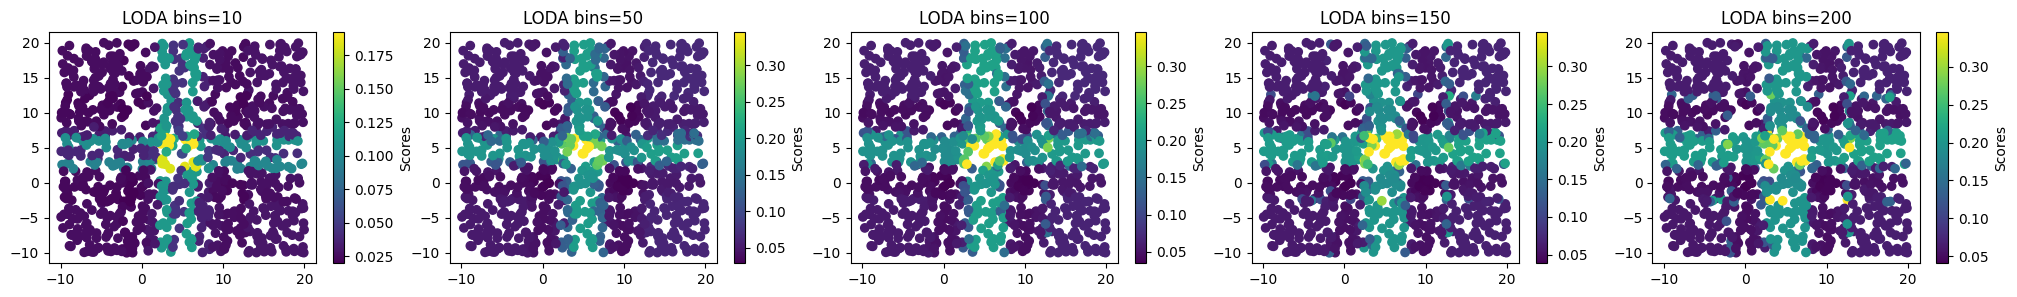

In [ ]:
def compare_loda_on_multiple_bins(
    train_data: np.ndarray,
    test_data: np.ndarray,
    contamination: float = 0.02,
    loda_bins: t.List[int] = [10, 50, 100, 150, 200]
) -> None:
  """
  Given a train and test dataset, with a certain contamination,
  compares the LODA model using different bins size.

  Plots the decision area for each model.
  """
  if train_data.shape[1] == 2:
    fig, axs = plt.subplots(1, len(loda_bins), figsize=(25, 3))
  else:
    fig, axs = plt.subplots(1, len(loda_bins), figsize=(25, 3), subplot_kw={'projection': '3d'})

  for i in range(len(loda_bins)):
    _loda = loda.LODA(contamination=contamination, n_bins=loda_bins[i])
    # fit the train data into a LODA model
    _loda.fit(train_data)
    # predict the test data and retrieve the confidence
    _loda_decision_area = _loda.decision_function(test_data)

    # add the decision area scatter to the plot
    loda_test_scatter = plot_decision_area(axs[i], test_data, _loda_decision_area)
    axs[i].set_title(f"LODA bins={loda_bins[i]}")
    plt.colorbar(loda_test_scatter, ax=axs[i], label='Scores')

  plt.show()

# compare the LODA method with differet bins
# for the 2D train and test datasets
compare_loda_on_multiple_bins(if_train_data, if_test_data)

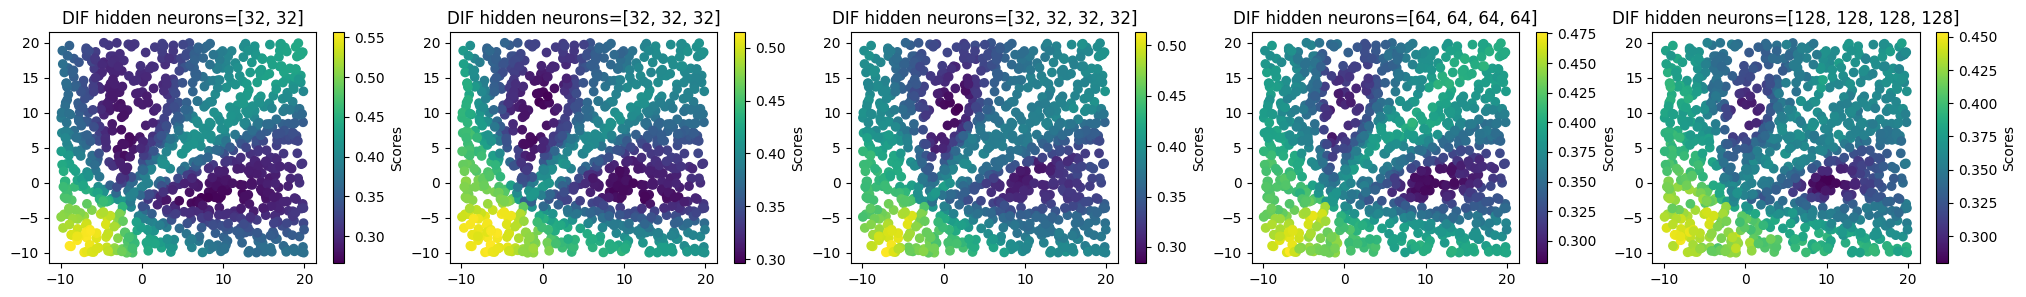

In [ ]:
def compare_dif_on_multiple_hidden_neurons(
    train_data: np.ndarray,
    test_data: np.ndarray,
    contamination: float = 0.02,
    hidden_neurons: t.List[t.List[int]] = [[32, 32], [32, 32, 32], [32, 32, 32, 32], [64, 64, 64, 64], [128, 128, 128, 128]]
) -> None:
  """
  Given a train and test dataset, with a certain contamination,
  compares the DIF model using different number of hidden neurons.

  Plots the decision area for each model.
  """
  if train_data.shape[1] == 2:
    fig, axs = plt.subplots(1, len(hidden_neurons), figsize=(25, 3))
  else:
    fig, axs = plt.subplots(1, len(hidden_neurons), figsize=(25, 3), subplot_kw={'projection': '3d'})

  for i in range(len(hidden_neurons)):
    _diforest = dif.DIF(contamination=contamination, hidden_neurons=hidden_neurons[i])
    # fit the train data into a deep isolation forest
    _diforest.fit(train_data)
    # predict the test data and retrieve the confidence
    _dif_decision_area = _diforest.decision_function(test_data)

    # add the decision area scatter to the plot
    dif_test_scatter = plot_decision_area(axs[i], test_data, _dif_decision_area)
    axs[i].set_title(f"DIF hidden neurons={hidden_neurons[i]}")
    plt.colorbar(dif_test_scatter, ax=axs[i], label='Scores')

  plt.show()

# compare the DIF method with hidden neurons
# for the 2D train and test datasets
compare_dif_on_multiple_hidden_neurons(if_train_data, if_test_data)

In [ ]:
# size of the train and test datasets
train_size = 1000
test_size = 1000

# generate train data with two clusters centered in (0, 10, 0) and (10, 0, 10)
train_data, train_labels = make_blobs(n_samples=train_size, n_features=3, centers=[(0, 10, 0), (10, 0, 10)], cluster_std=1)
# generate test data from uniform distribution
test_data = np.random.uniform(low=-10, high=20, size=(test_size, 3))

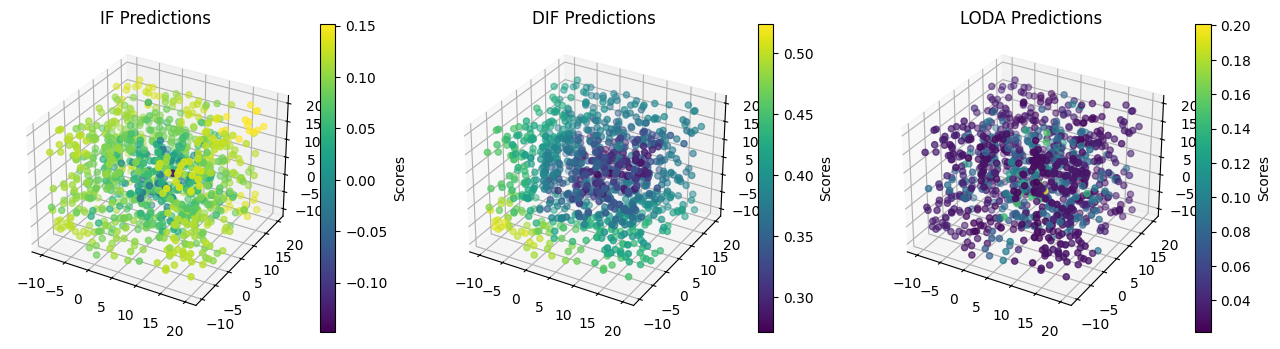

In [ ]:
# compare the IF, DIF and LODA methods
# for the 3D train and test datasets
compare_if_dif_loda(train_data, test_data)

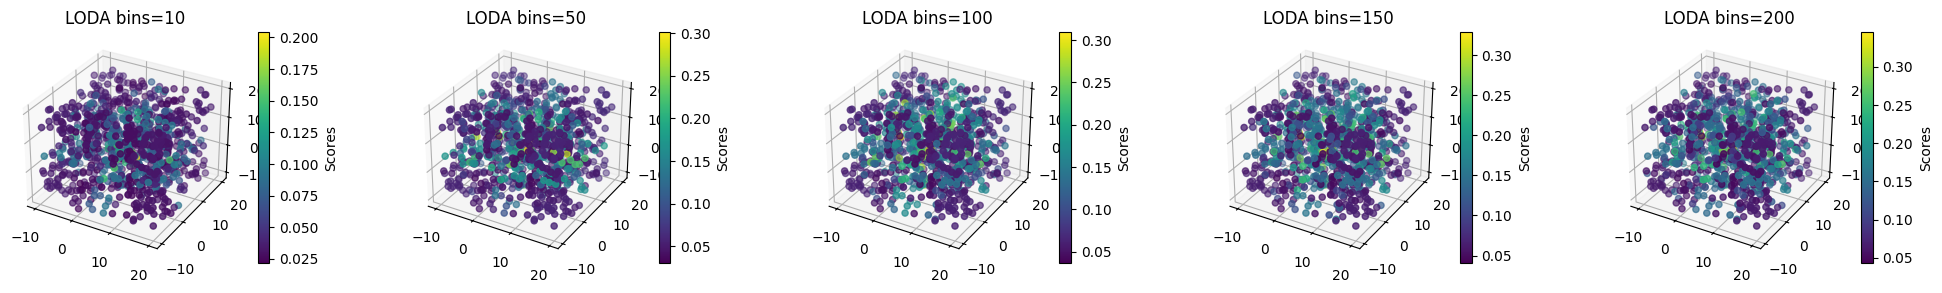

In [ ]:
# compare the LODA method with differet bins
# for the 3D train and test datasets
compare_loda_on_multiple_bins(train_data, test_data)

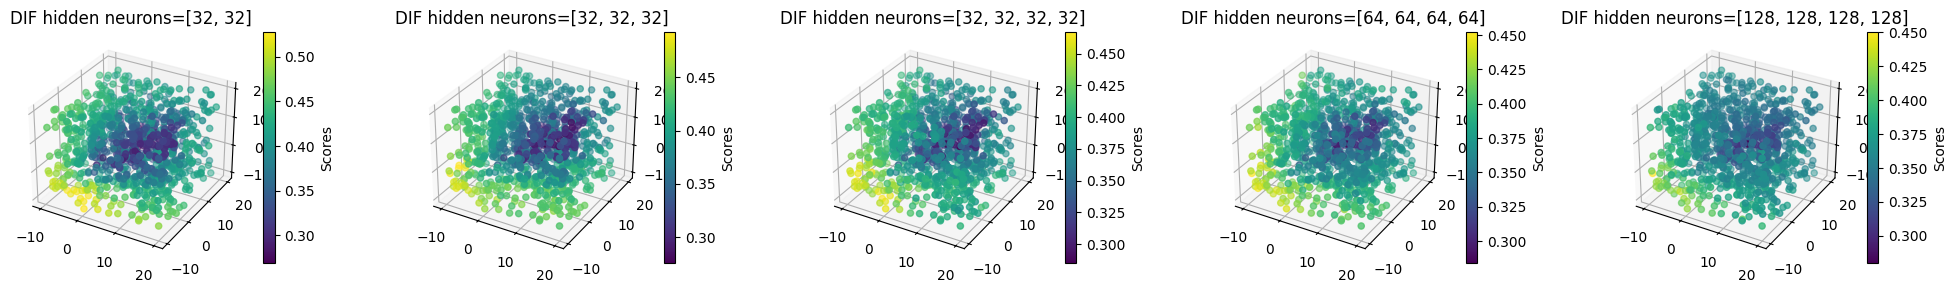

In [ ]:
# compare the DIF method with hidden neurons
# for the 3D train and test datasets
compare_dif_on_multiple_hidden_neurons(train_data, test_data)

# **Exercise 3:**

1. For this exercise we will need the shuttle dataset from ODDS (*https:
//odds.cs.stonybrook.edu/shuttle-dataset/*). Load the data using **scipy.io.loadmat()** and use **train_test_split()** to split it into train and
test subsets (use 40% of data for testing). Normalize your data accordingly.

2.  Fit IForest, LODA and DIF using the training data and compute the
balanced accuracy (**BA**) and the area under the curve (**ROC AUC** -
using **sklearn.metrics.roc_auc_score**) for each model. Compute the
mean **BA** and **ROC AUC** obtained for 10 different train-test splits for
each of the models.

In [5]:
!wget https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat

--2024-11-16 10:24:08--  https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘shuttle.mat’

shuttle.mat             [ <=>                ] 282.92K  --.-KB/s    in 0.01s   

2024-11-16 10:24:09 (20.6 MB/s) - ‘shuttle.mat’ saved [289712]



In [4]:
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

In [56]:
from sklearn.metrics import confusion_matrix, roc_auc_score

class Metrics:
    @staticmethod
    def balanced_accuracy(labels: np.ndarray, predictions: np.ndarray) -> float:
        tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0, 1]).ravel()

        # compute recall, sensitivity
        tpr = tp / (tp + fn)
        # compute specificity
        tnr = tn / (tn + fp)
        # compute balanced accuracy
        ba = (tpr + tnr) / 2

        return ba

In [66]:
# load the shuttle dataset
shuttle_dataset = loadmat("shuttle.mat")
shuttle_samples, shuttle_labels = shuttle_dataset["X"], shuttle_dataset["y"]
shuttle_contamination = round(np.sum(shuttle_labels == 1) / len(shuttle_samples), 5)

In [67]:
# standardize the samples
shuttle_samples = (shuttle_samples - np.mean(shuttle_samples, axis=0)) / np.std(shuttle_samples, axis=0)

In [68]:
# split the dataset into train and test subsets
shuttle_train_samples, shuttle_test_samples, shuttle_train_labels, shuttle_test_labels = train_test_split(shuttle_samples, shuttle_labels, test_size=0.4)
shuttle_train_labels = np.squeeze(shuttle_train_labels, axis=1)
shuttle_test_labels = np.squeeze(shuttle_test_labels, axis=1)

In [78]:
import torch

def compare_ba_and_roc_auc(
  train_samples: np.ndarray,
  train_labels: np.ndarray,
  test_samples: np.ndarray,
  test_labels: np.ndarray,
  contamination: float = 0.2,
  test_size: float = 40.00,
) -> tuple[float]:
  """
  Given a train dataset and a test dataset,
  trains IF, DIF and LODA, and then compares the balanced
  accuracy between these methods.

  Also plots the ROC AUC score for each model.
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"

  _iforest = iforest.IForest(contamination=contamination)
  _iforest.fit(train_samples)
  # compute predictions and scores for IF
  _iforest_predictions = _iforest.predict(test_samples)
  _iforest_scores = _iforest.decision_function(test_samples)

  # compute the metrics for IF
  _iforest_ba = Metrics.balanced_accuracy(test_labels, _iforest_predictions)
  _iforest_roc_auc_score = roc_auc_score(test_labels, _iforest_scores)

  _diforest = dif.DIF(contamination=contamination, device=device)
  _diforest.fit(train_samples)
  # compute predictions and scores for IF
  _diforest_predictions = _diforest.predict(test_samples)
  _diforest_scores = _diforest.decision_function(test_samples)
  # compute the metrics for IF
  _diforest_ba = Metrics.balanced_accuracy(test_labels, _diforest_predictions)
  _diforest_roc_auc_score = roc_auc_score(test_labels, _diforest_scores)

  _loda = loda.LODA(contamination=contamination)
  _loda.fit(train_samples)
  # compute predictions and scores for IF
  _loda_predictions = _loda.predict(test_samples)
  _loda_scores = _loda.decision_function(test_samples)
  # compute the metrics for IF
  _loda_ba = Metrics.balanced_accuracy(test_labels, _loda_predictions)
  _loda_roc_auc_score = roc_auc_score(test_labels, _loda_scores)

  print(f"IF vs DIF vs LODA for {test_size}% testing data:")
  print("------------------------------------------------------")
  print(f"IF ----> BA: {_iforest_ba:.5f} ROC_AUC: {_iforest_roc_auc_score:.5f}")
  print(f"DIF ---> BA: {_diforest_ba:.5f} ROC_AUC: {_diforest_roc_auc_score:.5f}")
  print(f"LODA --> BA: {_loda_ba:.5f} ROC_AUC: {_loda_roc_auc_score:.5f}")
  print()

  return _iforest_ba, _iforest_roc_auc_score, _diforest_ba, _diforest_roc_auc_score, _loda_ba, _loda_roc_auc_score

In [70]:
# print metrics for shuttle data from
# which 40% was used for testing
compare_ba_and_roc_auc(
    shuttle_train_samples,
    shuttle_train_labels,
    shuttle_test_samples,
    shuttle_test_labels,
    contamination=shuttle_contamination
)

IF vs DIF vs LODA for 40.0% testing data:
------------------------------------------------------
IF ----> BA: 0.95618 ROC_AUC: 0.99631
DIF ---> BA: 0.50834 ROC_AUC: 0.96564
LODA --> BA: 0.46293 ROC_AUC: 0.10358



(0.95618, 0.99631, 0.50834, 0.96564, 0.46293, 0.10358)

In [73]:
test_sizes = [20, 25, 30, 35, 40]
if_bas, if_roc_aucs = [], []
dif_bas, dif_roc_aucs = [], []
loda_bas, loda_roc_aucs = [], []

for test_size in test_sizes:
  # split the shuttle dataset according to the current test size
  # use stratify because sometimes there are only one class labels in the testing dataset
  shuttle_train_samples, shuttle_test_samples, shuttle_train_labels, shuttle_test_labels = train_test_split(shuttle_samples, shuttle_labels, stratify=shuttle_labels, test_size=test_size)
  shuttle_train_labels = np.squeeze(shuttle_train_labels, axis=1)
  shuttle_test_labels = np.squeeze(shuttle_test_labels, axis=1)

  # train and fit IF, DIF and LODA
  if_ba, if_roc_auc_score, dif_ba, dif_roc_auc_score, loda_ba, loda_roc_auc_score = compare_ba_and_roc_auc(
    shuttle_train_samples,
    shuttle_train_labels,
    shuttle_test_samples,
    shuttle_test_labels,
    contamination=shuttle_contamination,
    test_size=test_size
  )

  if_bas.append(if_ba)
  if_roc_aucs.append(if_roc_auc_score)
  dif_bas.append(dif_ba)
  dif_roc_aucs.append(dif_roc_auc_score)
  loda_bas.append(loda_ba)
  loda_roc_aucs.append(loda_roc_auc_score)

IF vs DIF vs LODA for 20% testing data:
------------------------------------------------------
IF ----> BA: 1.0 ROC_AUC: 1.0
DIF ---> BA: 0.5 ROC_AUC: 0.94737
LODA --> BA: 0.44737 ROC_AUC: 0.73684

IF vs DIF vs LODA for 25% testing data:
------------------------------------------------------
IF ----> BA: 1.0 ROC_AUC: 1.0
DIF ---> BA: 0.5 ROC_AUC: 1.0
LODA --> BA: 1.0 ROC_AUC: 1.0

IF vs DIF vs LODA for 30% testing data:
------------------------------------------------------
IF ----> BA: 1.0 ROC_AUC: 1.0
DIF ---> BA: 0.5 ROC_AUC: 0.98214
LODA --> BA: 0.71429 ROC_AUC: 0.92857

IF vs DIF vs LODA for 35% testing data:
------------------------------------------------------
IF ----> BA: 1.0 ROC_AUC: 1.0
DIF ---> BA: 0.5 ROC_AUC: 0.98958
LODA --> BA: 0.81771 ROC_AUC: 0.82292

IF vs DIF vs LODA for 40% testing data:
------------------------------------------------------
IF ----> BA: 0.83333 ROC_AUC: 0.96396
DIF ---> BA: 0.5 ROC_AUC: 0.78378
LODA --> BA: 0.83333 ROC_AUC: 0.91441



In [77]:
print(f"Average metrics for using test sizes: {test_sizes}")
print("---------------------------------------------------")
print(f"IF ----> BA: {np.mean(if_bas):.5f} ROC_AUC: {np.mean(if_roc_aucs):.5f}")
print(f"DIF ---> BA: {np.mean(dif_bas):.5f} ROC_AUC: {np.mean(dif_roc_aucs):.5f}")
print(f"LODA --> BA: {np.mean(loda_bas):.5f} ROC_AUC: {np.mean(loda_roc_aucs):.5f}")

Average metrics for using test sizes: [20, 25, 30, 35, 40]
---------------------------------------------------
IF ----> BA: 0.96667 ROC_AUC: 0.99279
DIF ---> BA: 0.50000 ROC_AUC: 0.94057
LODA --> BA: 0.76254 ROC_AUC: 0.88055
